2023-08-08 09:11:10.565050: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 09:11:10.566595: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 09:11:10.597037: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 09:11:10.597576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 09:11:11.339507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

1/1 [==============================] - 0s 13ms/step
Estimated parameters: k1 = 5.0021654, k2 = 1.0108833
Computed parameters: k1 = 5.0021654, k2 = 1.0108833
Computational time: 108.74969601631165 seconds


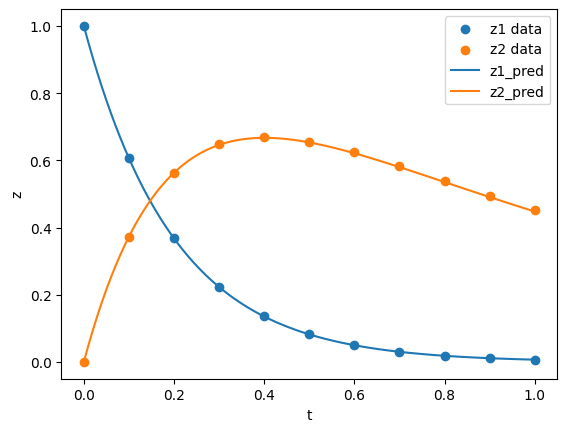

In [1]:
# Import necessary libraries
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

# Start the timer
start_time = time.time()

# Define constants for the problem
initial_conditions = [1.0, 0.0]
t = np.linspace(0, 1, 11)
u1_u2 = np.array([
    [1.000000, 0.000000],
    [0.606531, 0.372883],
    [0.367879, 0.563564],
    [0.223130, 0.647110],
    [0.135335, 0.668731],
    [0.082085, 0.655557],
    [0.049787, 0.623781],
    [0.030197, 0.582985],
    [0.018316, 0.538767],
    [0.011109, 0.494326],
    [0.006738, 0.451427]
])
architecture = [1, 40, 2]  # One input layer, one hidden layer with 40 neurons, and one output layer

# Define the model
model = tf.keras.Sequential()
model.add(layers.Dense(40, activation='sigmoid', input_shape=(1,)))  # Hidden layer
model.add(layers.Dense(2))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(t, u1_u2, epochs=90000, verbose=0)

# Define the system of differential equations
def system(u, t, k1, k2):
    return [-k1*u[0], k1*u[0] - k2*u[1]]

# Define the function to solve the non-linear system
def solve_nonlinear_system(p):
    u = odeint(system, initial_conditions, t, args=tuple(p))
    return np.sum(u, axis=0) - np.sum(model.predict(t), axis=0)


# Initial guess for the parameters
initial_guess = [1, 1]

# Use fsolve to solve the non-linear system
k1, k2 = fsolve(solve_nonlinear_system, initial_guess)

print(f"Estimated parameters: k1 = {k1:.7f}, k2 = {k2:.7f}")


# Stop the timer
end_time = time.time()

# Compute the computational time
comp_time = end_time - start_time

print(f"Computed parameters: k1 = {k1:.7f}, k2 = {k2:.7f}")
print(f"Computational time: {comp_time} seconds")

# Generate more points for a smoother plot
t_fine = np.linspace(0, 1, 100)
u_fine = odeint(system, initial_conditions, t_fine, args=(k1, k2))

# Plot the original data
plt.scatter(t, u1_u2[:, 0], label='z1 data')
plt.scatter(t, u1_u2[:, 1], label='z2 data')

# Plot the fitted curves
plt.plot(t_fine, u_fine[:, 0], label='z1_pred')
plt.plot(t_fine, u_fine[:, 1], label='z2_pred')

plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.show()

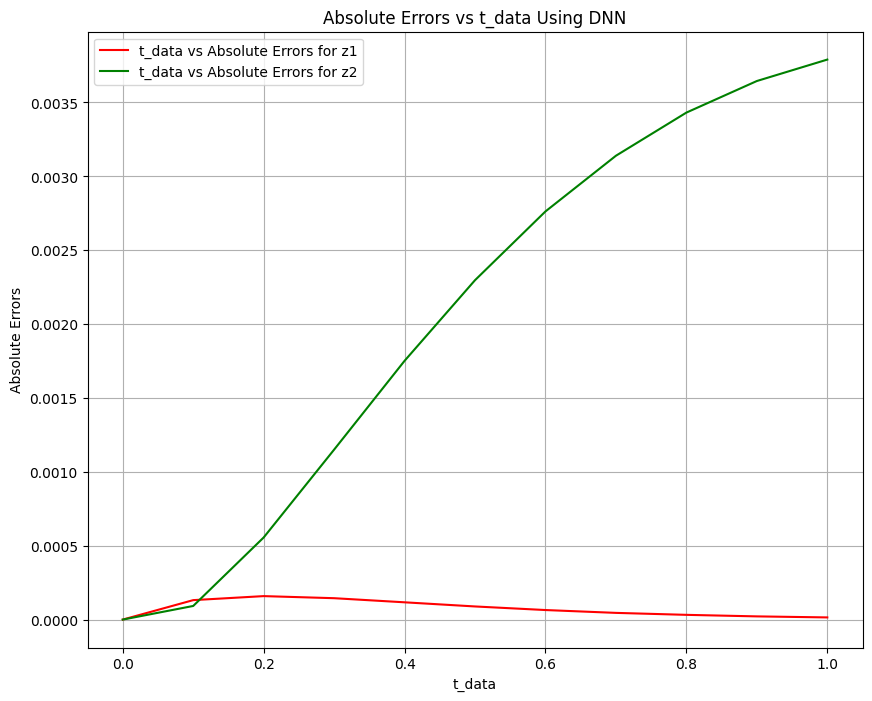

In [2]:
# Generate more points for a smoother plot
t_fine = np.linspace(0, 1, 100)
u_fine = odeint(system, initial_conditions, t_fine, args=(k1, k2))

# Generate points for original t values
u_pred = odeint(system, initial_conditions, t, args=(k1, k2))


# plot the absolute errors between the target and the predictions (make sure u1_u2 and t are defined properly)
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t, np.abs(u1_u2[:, 0] - u_pred[:, 0]), 'r')
plt.plot(t, np.abs(u1_u2[:, 1] - u_pred[:, 1]), 'g')
plt.xlabel('t_data')
plt.ylabel("Absolute Errors")
plt.legend(["t_data vs Absolute Errors for z1", "t_data vs Absolute Errors for z2"])
plt.grid(True)
plt.title("Absolute Errors vs t_data Using DNN")
plt.show()


In [3]:
# calculate the R-squared
from sklearn.metrics import r2_score
r2_u1 = r2_score(u1_u2[:, 0], u_pred[:, 0])
r2_u2 = r2_score(u1_u2[:, 1], u_pred[:, 1])
print(f"R-squared for u1: {r2_u1}")
print(f"R-squared for u2: {r2_u2}")

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_u1 = mean_absolute_error(u1_u2[:, 0], u_pred[:, 0])
mae_u2 = mean_absolute_error(u1_u2[:, 1], u_pred[:, 1])
print(f"Mean absolute error for u1: {mae_u1}")
print(f"Mean absolute error for u2: {mae_u2}")

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_u1 = mean_squared_error(u1_u2[:, 0], u_pred[:, 0])
mse_u2 = mean_squared_error(u1_u2[:, 1], u_pred[:, 1])
print(f"Mean squared error for u1: {mse_u1}")
print(f"Mean squared error for u2: {mse_u2}")

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_u1 = mean_squared_error(u1_u2[:, 0], u_pred[:, 0], squared=False)
rmse_u2 = mean_squared_error(u1_u2[:, 1], u_pred[:, 1], squared=False)
print(f"Root mean squared error for u1: {rmse_u1}")
print(f"Root mean squared error for u2: {rmse_u2}")

# calculate the Explained variance score
from sklearn.metrics import explained_variance_score
evs_u1 = explained_variance_score(u1_u2[:, 0], u_pred[:, 0])
evs_u2 = explained_variance_score(u1_u2[:, 1], u_pred[:, 1])
print(f"Explained variance score for u1: {evs_u1}")
print(f"Explained variance score for u2: {evs_u2}")


R-squared for u1: 0.9999999069416575
R-squared for u2: 0.9998190236296293
Mean absolute error for u1: 7.447792280750918e-05
Mean absolute error for u2: 0.002056111986479819
Mean squared error for u1: 8.455965216175386e-09
Mean squared error for u2: 6.082745683630509e-06
Root mean squared error for u1: 9.195632232845867e-05
Root mean squared error for u2: 0.002466322299220138
Explained variance score for u1: 0.9999999679862552
Explained variance score for u2: 0.999944804832712


___________________

1/1 [==============================] - 0s 14ms/step
Estimated parameters: k1 = 4.9997467, k2 = 1.0005808
Computed parameters: k1 = 4.9997467, k2 = 1.0005808
Computational time: 26.376427173614502 seconds


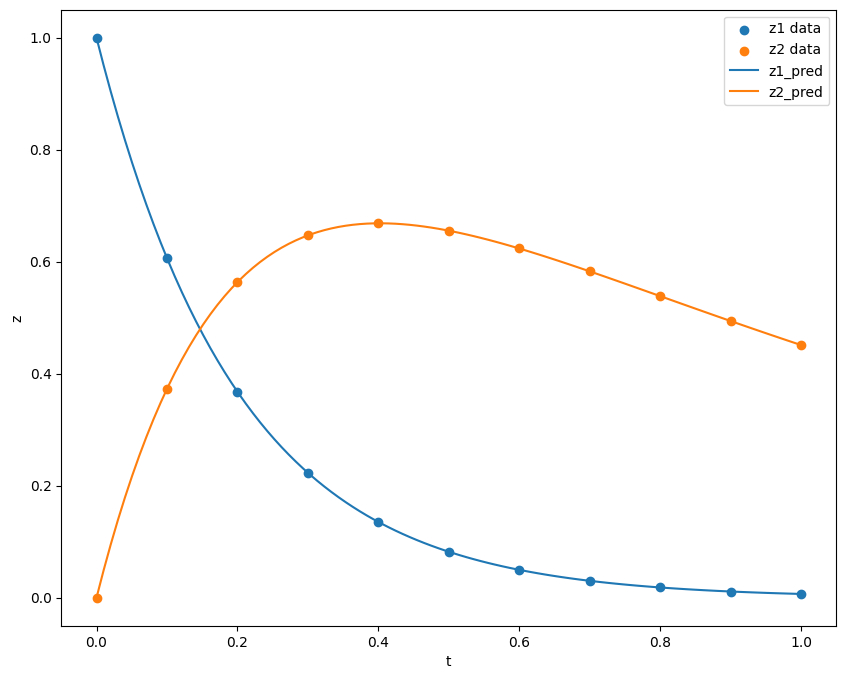

In [4]:
# Import necessary libraries
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

# Start the timer
start_time = time.time()


architecture = [1, 40, 2]  # One input layer, one hidden layer with 40 neurons, and one output layer

# Define the model
model = tf.keras.Sequential()
model.add(layers.Dense(40, activation='sigmoid', input_shape=(1,)))  # Hidden layer
model.add(layers.Dense(2))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(t, u1_u2, epochs=21378, verbose=0)

# Define the system of differential equations
def system(u, t, k1, k2):
    return [-k1*u[0], k1*u[0] - k2*u[1]]

# Define the function to solve the non-linear system
def solve_nonlinear_system(p):
    u = odeint(system, initial_conditions, t, args=tuple(p))
    return np.sum(u, axis=0) - np.sum(model.predict(t), axis=0)


# Initial guess for the parameters
initial_guess = [1, 1]

# Use fsolve to solve the non-linear system
k1, k2 = fsolve(solve_nonlinear_system, initial_guess)

print(f"Estimated parameters: k1 = {k1:.7f}, k2 = {k2:.7f}")


# Stop the timer
end_time = time.time()

# Compute the computational time
comp_time = end_time - start_time

print(f"Computed parameters: k1 = {k1:.7f}, k2 = {k2:.7f}")
print(f"Computational time: {comp_time} seconds")

# Generate more points for a smoother plot
t_fine = np.linspace(0, 1, 100)
u_fine = odeint(system, initial_conditions, t_fine, args=(k1, k2))

# Plot the original data
plt.scatter(t, u1_u2[:, 0], label='z1 data')
plt.scatter(t, u1_u2[:, 1], label='z2 data')

# Plot the fitted curves
plt.plot(t_fine, u_fine[:, 0], label='z1_pred')
plt.plot(t_fine, u_fine[:, 1], label='z2_pred')

plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.show()

______

1/1 [==============================] - 0s 15ms/step
Estimated parameters: k1 = 4.9781791, k2 = 0.9961604
Computed parameters: k1 = 4.9781791, k2 = 0.9961604
Computational time: 31.119527578353882 seconds


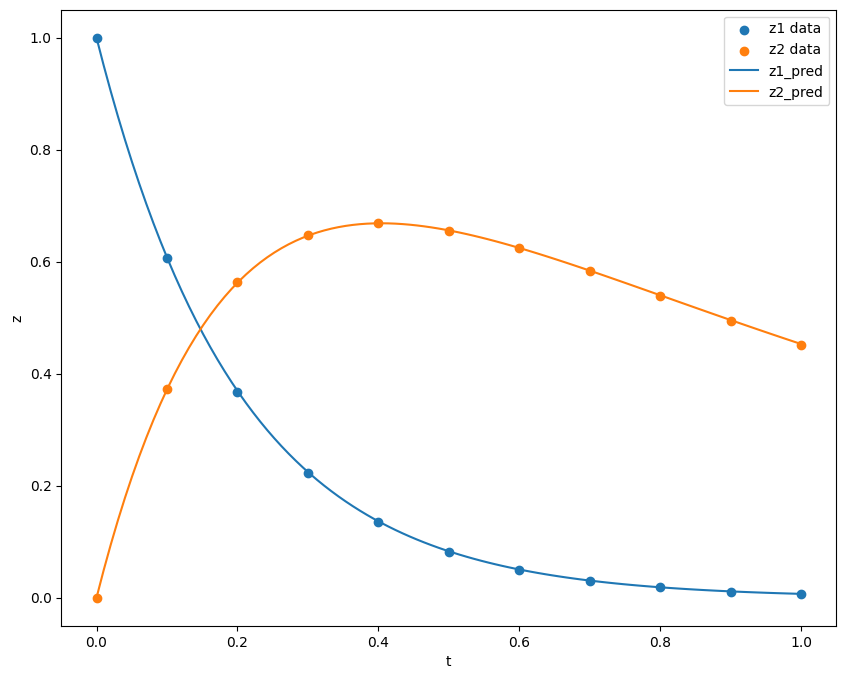

In [5]:
# Import necessary libraries
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

# Start the timer
start_time = time.time()


architecture = [1, 40, 40, 2]  # One input layer, two hidden layers with 40 neurons each, and one output layer

# Define the updated model
model = tf.keras.Sequential()
model.add(layers.Dense(40, activation='sigmoid', input_shape=(1,)))  # First hidden layer
model.add(layers.Dense(40, activation='sigmoid'))  # Second hidden layer
model.add(layers.Dense(2))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(t, u1_u2, epochs=24358, verbose=0)

# Define the system of differential equations
def system(u, t, k1, k2):
    return [-k1*u[0], k1*u[0] - k2*u[1]]

# Define the function to solve the non-linear system
def solve_nonlinear_system(p):
    u = odeint(system, initial_conditions, t, args=tuple(p))
    return np.sum(u, axis=0) - np.sum(model.predict(t), axis=0)


# Initial guess for the parameters
initial_guess = [1, 1]

# Use fsolve to solve the non-linear system
k1, k2 = fsolve(solve_nonlinear_system, initial_guess)

print(f"Estimated parameters: k1 = {k1:.7f}, k2 = {k2:.7f}")


# Stop the timer
end_time = time.time()

# Compute the computational time
comp_time = end_time - start_time

print(f"Computed parameters: k1 = {k1:.7f}, k2 = {k2:.7f}")
print(f"Computational time: {comp_time} seconds")

# Generate more points for a smoother plot
t_fine = np.linspace(0, 1, 100)
u_fine = odeint(system, initial_conditions, t_fine, args=(k1, k2))

# Plot the original data
plt.scatter(t, u1_u2[:, 0], label='z1 data')
plt.scatter(t, u1_u2[:, 1], label='z2 data')

# Plot the fitted curves
plt.plot(t_fine, u_fine[:, 0], label='z1_pred')
plt.plot(t_fine, u_fine[:, 1], label='z2_pred')

plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.show()

_____

1/1 [==============================] - 0s 14ms/step
Estimated parameters: k1 = 4.9434000, k2 = 1.0251681
Computed parameters: k1 = 4.9434000, k2 = 1.0251681
Computational time: 22.069233417510986 seconds


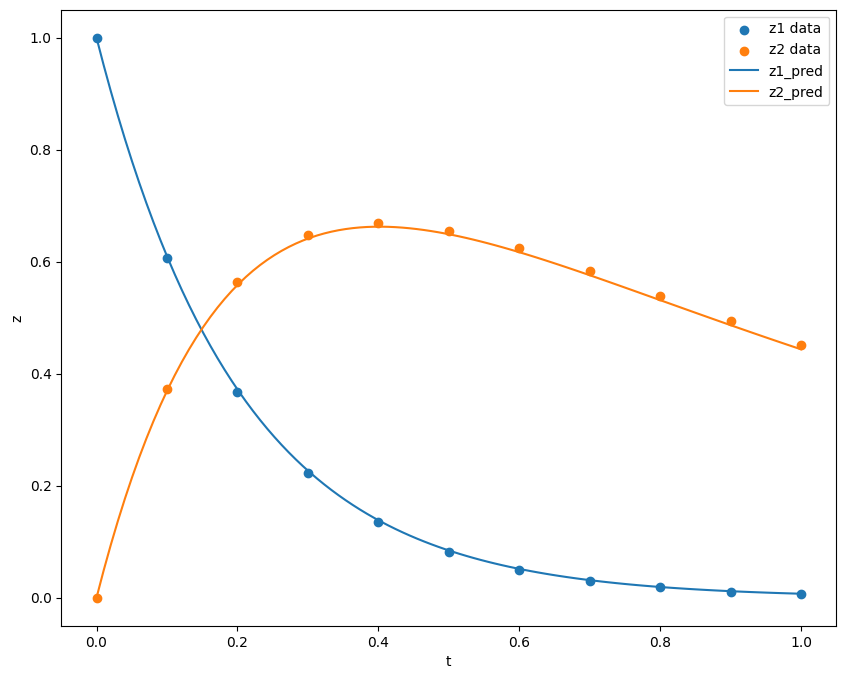

In [6]:
# Import necessary libraries
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

# Start the timer
start_time = time.time()


#Updated architecture
architecture = [1, 40, 40, 40, 2]  # One input layer, three hidden layers with 40 neurons each, and one output layer

# Define the updated model
model = tf.keras.Sequential()
model.add(layers.Dense(40, activation='sigmoid', input_shape=(1,)))  # First hidden layer
model.add(layers.Dense(40, activation='sigmoid'))  # Second hidden layer
model.add(layers.Dense(40, activation='sigmoid'))  # Third hidden layer
model.add(layers.Dense(2))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(t, u1_u2, epochs=16021, verbose=0)

# Define the system of differential equations
def system(u, t, k1, k2):
    return [-k1*u[0], k1*u[0] - k2*u[1]]

# Define the function to solve the non-linear system
def solve_nonlinear_system(p):
    u = odeint(system, initial_conditions, t, args=tuple(p))
    return np.sum(u, axis=0) - np.sum(model.predict(t), axis=0)


# Initial guess for the parameters
initial_guess = [1, 1]

# Use fsolve to solve the non-linear system
k1, k2 = fsolve(solve_nonlinear_system, initial_guess)

print(f"Estimated parameters: k1 = {k1:.7f}, k2 = {k2:.7f}")


# Stop the timer
end_time = time.time()

# Compute the computational time
comp_time = end_time - start_time

print(f"Computed parameters: k1 = {k1:.7f}, k2 = {k2:.7f}")
print(f"Computational time: {comp_time} seconds")

# Generate more points for a smoother plot
t_fine = np.linspace(0, 1, 100)
u_fine = odeint(system, initial_conditions, t_fine, args=(k1, k2))

# Plot the original data
plt.scatter(t, u1_u2[:, 0], label='z1 data')
plt.scatter(t, u1_u2[:, 1], label='z2 data')

# Plot the fitted curves
plt.plot(t_fine, u_fine[:, 0], label='z1_pred')
plt.plot(t_fine, u_fine[:, 1], label='z2_pred')

plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.show()